# Chapter 2: Loading and visualizing data

In [1]:
import configparser
from getpass import getuser
config = configparser.ConfigParser()
config.read(f"../config/{getuser()}.ini")
if len(config.sections()) == 0:
    config.read("../config/default.ini")
DATA_PATH = config["Data"]["path"]

## Construct a DataFrame from the .json files

In [2]:
import os
import json
import pandas as pd

data = []

for file in os.listdir(DATA_PATH):
    if file.endswith(".json"):
        with open(os.path.join(DATA_PATH, file), "r") as f:
            data.append(json.load(f))

df = pd.DataFrame(data)
df["Time_Published"] = pd.to_datetime(df["Time_Published"])
df["Sentiment"] = df.apply(lambda x: 1 if x["Polarity"] > 0.1 else 0 if abs(x["Polarity"]) <= 0.1 else -1, axis=1)
df = df[df["Positive"] + df["Negative"] > 2] # Only keep entries with more than 2 votes

from sklearn.utils import shuffle
df = shuffle(df, random_state=10)

print(df.shape)

(6602, 11)


First few entries in the DataFrame

In [3]:
df.head()

,Title,URL,Time_Published,Body_Text,Company,Symbol,Positive,Negative,Polarity,News_Id,Sentiment
2207,"JIAYUAN SER (01153.HK) Priced at $3.86, One-lo...",http://www.aastocks.com/en/stocks/news/aafn-co...,2020-12-08 08:33:00,"JIAYUAN SER, to be listed tomorrow, was priced...",JIAYUAN SER,01153.HK,8,11,-0.157895,NOW.1061565,-1
6999,Chevron Mulls Taking Over Noble Midstream,http://www.aastocks.com/en/stocks/news/aafn-co...,2021-02-06 10:53:00,Chevron announced proposed privatisation of pi...,,,3,0,1.000000,NOW.1074790,1
5834,CK ASSET (01113.HK)'s 'Seaside Sonata' Sells 6...,http://www.aastocks.com/en/stocks/news/aafn-co...,2021-01-25 16:23:00,CK ASSET announced that Seaside Sonata has to ...,CK ASSET,01113.HK,26,16,0.238095,NOW.1071583,1
4908,UBS Hikes INNOVENT BIO (01801.HK) TP to $112.8...,http://www.aastocks.com/en/stocks/news/aafn-co...,2021-01-14 10:14:00,China's leading biotech firm INNOVENT BIO boas...,China's leading biotech firm INNOVENT BIO,01801.HK,29,13,0.380952,NOW.1069127,1
1938,12 SHK Malls Expected to Post 8% MoM Growth of...,http://www.aastocks.com/en/stocks/news/aafn-co...,2020-12-03 18:13:00,The 12 shopping malls of SHK PPT were projecte...,The 12 shopping malls of SHK PPT,00016.HK,7,9,-0.125000,NOW.1060893,-1


## Save the DataFrame for later chapters

In [4]:
df.to_pickle(os.path.join(DATA_PATH, "df.pkl"))

## Load the pickle back into a DataFrame

In [5]:
import os
import pandas as pd
df = pd.read_pickle(os.path.join(DATA_PATH, "df.pkl"))
print(df.shape)

(6602, 11)


## Visualizing the data

### Polarity-Time chart

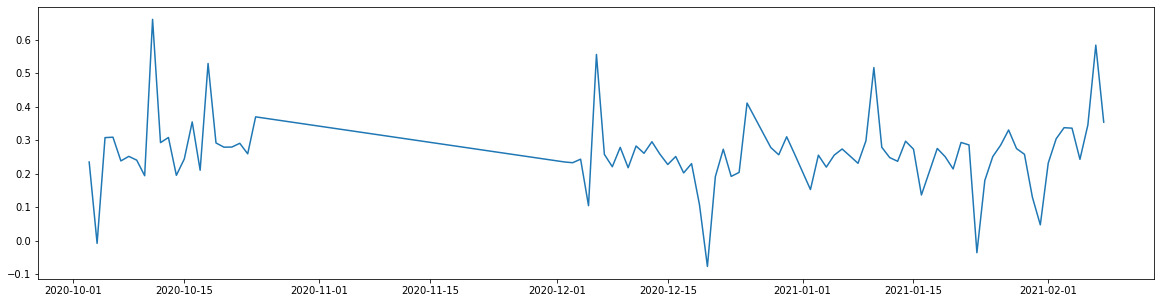

In [6]:
df_date_only = df.copy()
df_date_only["Time_Published"] = df["Time_Published"].dt.floor("d")
df_by_date = df_date_only.groupby(["Time_Published"], as_index=False).mean()
df_by_date.head()

import matplotlib.pyplot as plt
plt.figure(figsize=(20,5))
plt.plot(df_by_date["Time_Published"], df_by_date["Polarity"])

### Box plot for a date

In [7]:
import ipywidgets as widgets
wg = widgets.Dropdown(
    options=[(t.strftime("%Y-%m-%d"), t) for t in df_date_only["Time_Published"].drop_duplicates().to_list()],
    description='Date:'
)

out = widgets.Output()
display(out)
@out.capture()
def plot_box_plot(change):
    out.clear_output()
    df_date_only[df_date_only["Time_Published"] == wg.value].boxplot(column=["Polarity"])
    plt.show()

wg.on_displayed(plot_box_plot)
wg.observe(plot_box_plot, names=["value"])
display(wg)

Output()

Dropdown(description='Date:', options=(('2020-12-08', Timestamp('2020-12-08 00:00:00')), ('2021-02-06', Timest…

### Distribution of polarities

<BarContainer object of 3 artists>

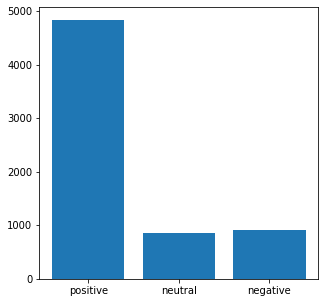

In [8]:
distr = {
    "positive": len(df[df["Sentiment"] == 1]),
    "neutral": len(df[df["Sentiment"] == 0]),
    "negative": len(df[df["Sentiment"] == -1]),
}

plt.figure(figsize=(5,5))
plt.bar(distr.keys(), distr.values())

So, the data is skewed towards the positive side (which is quite normal for crowdsourced sentiments like that on Stocktwits).

## Baseline using Zero Rule

In [9]:
print("Baseline accuracy:", max(distr.values()) / sum(distr.values()))

Baseline accuracy: 0.7326567706755529
